#  Прогнозирование заказов такси

Компания «Чётенькое такси» <i>(🤦‍♂️ В Яндексе точно кто-то из уральских пельменей работает)</i> собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

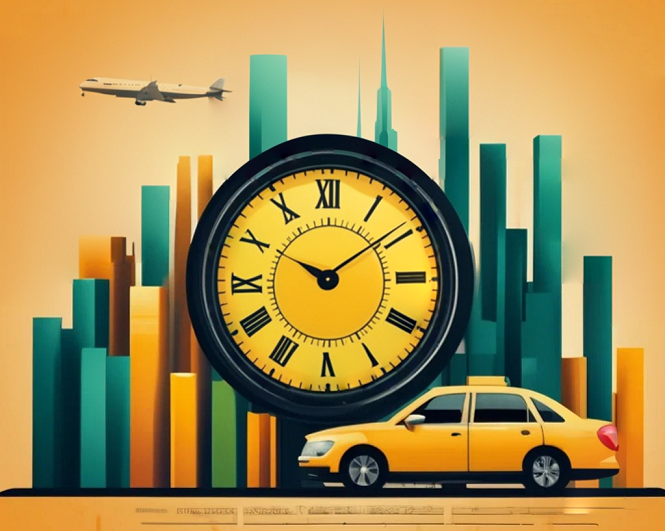

Для заказчика необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.
5. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Результаты-валидации-моделей" data-toc-modified-id="Результаты-валидации-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Результаты валидации моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка

In [19]:
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor #для проверки адекватности модели

In [20]:
try:
    df = pd.read_csv('C://datasets/taxi.csv', index_col=[0], parse_dates=[0])


except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

display(df.info())
display(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<AxesSubplot:xlabel='datetime'>

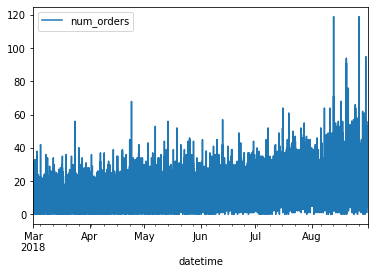

In [21]:
df.plot()

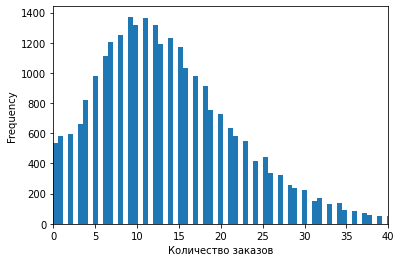

In [34]:
ax = df.plot.hist(bins = 200, xlim = (0,40), legend = False)
ax.set_xlabel('Количество заказов')
None

In [23]:
df.index.is_monotonic

True

- Данные распределены нормально, отсечёны в нуле;

- В наличии данные с 1 марта по 31 августа 2018 года;
    
- Данные монотонны.

Рассмотрим данные.

<AxesSubplot:xlabel='hour'>

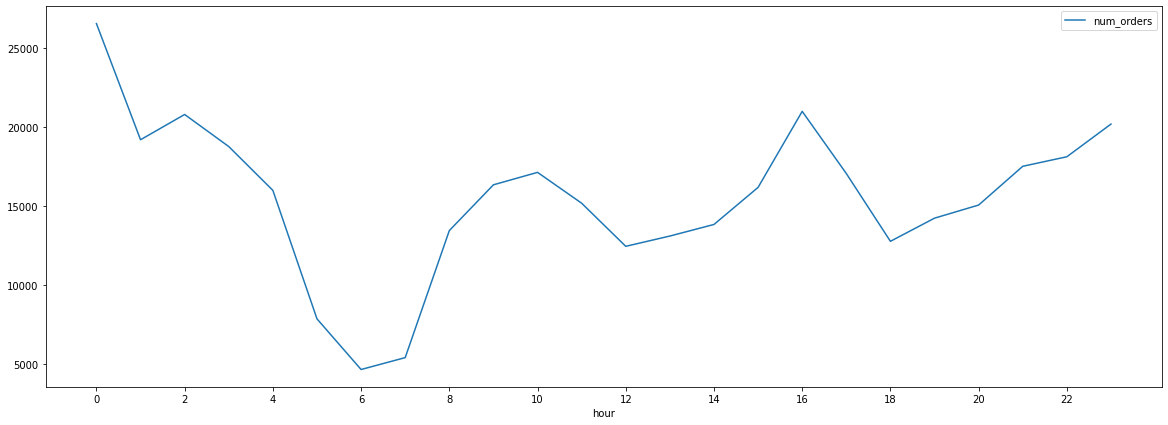

In [24]:
df['hour'] = df.index.hour
taxy_by_hour = df.pivot_table(
    index = 'hour', values = 'num_orders', aggfunc = 'sum')
taxy_by_hour.plot(figsize = (20,7),xticks = [0,2,4,6,8,10,12,14,16,18,20,22])

<AxesSubplot:xlabel='weekday'>

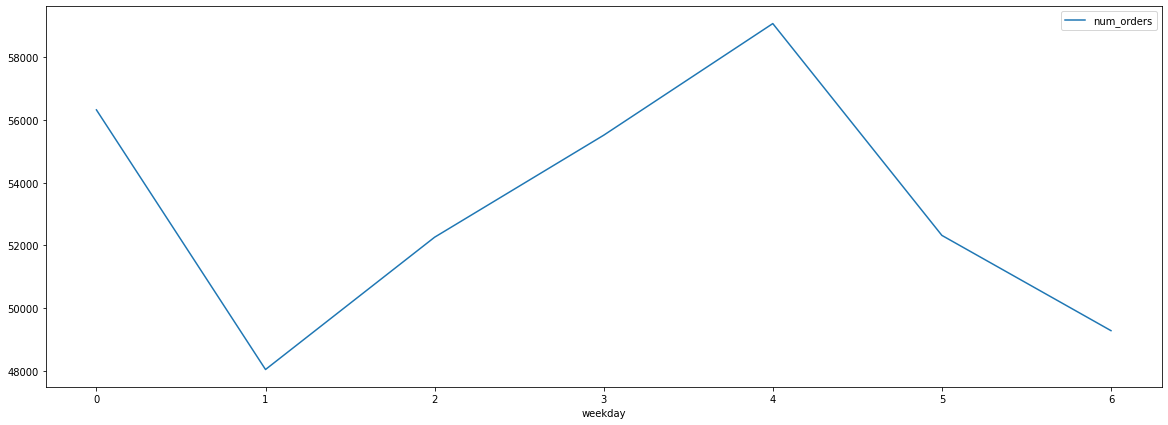

In [25]:
df['weekday'] = df.index.weekday
taxy_by_weekday = df.pivot_table(
    index = 'weekday', values = 'num_orders', aggfunc = 'sum')
taxy_by_weekday.plot(figsize = (20,7),xticks = [0,1,2,3,4,5,6])

- По дням недели:
    0 - понедельник - спрос на такис высокий.
    Со вторника по пятницу спрос стабильно растет, достигая пика к пятнице и падает в субботу и воскресение.
    
По всей видимости - такси в основном используют для поездок из дома или домой, усталось растет в течении недели и заказы такси растут вместе с ней. Интересно, конечно, из какого города данные. По всей видимости из крупного.
    
- По часам:
    
    Три выраженных пика - с 8 до 10 (на работу), с 14 до 18 (с работы видимо) и 22 - 2 ночи - возвращение с вечерних "мероприятий". Ну и ожидаемый провал в 3 - 7 утра - большинство пользователей спит.
    
- Удалим более не нужные столбцы. Сделаем ресемпл по часу, но перед этим ещё чуть-чуть посмотрим данные.
    

In [26]:
df = df.drop(['hour', 'weekday'], axis = 1)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


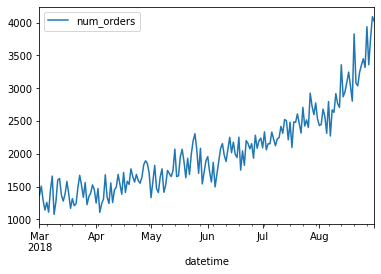

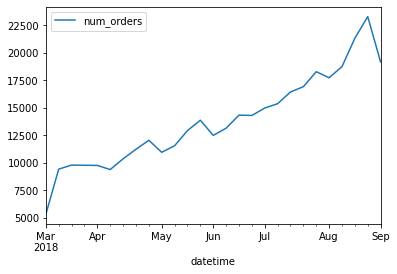

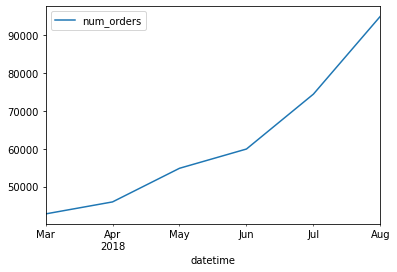

In [37]:
df_by_day = df.resample('1D').sum()
df_by_day.plot()

df_by_week = df.resample('1W').sum()
df_by_week.plot()

df_by_month = df.resample('1M').sum()
df_by_month.plot()
None

In [38]:
df_by_month

,num_orders
datetime,
2018-03-31,42768
2018-04-30,45939
2018-05-31,54820
2018-06-30,59906
2018-07-31,74405
2018-08-31,94973


- Популярность сервиса растет, судя по графикам, ежедневное число заказов с марта по сентябрь увеличилось с ~1250 до 4000!
    
- Месячный показатель вырос в 2.2 раза. 
    
- Проведём почасовой ре-сэмпл заданию заказчика.


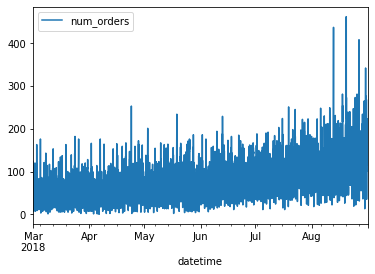

In [40]:
df=df.resample('1H').sum()
df.plot()
None

## Анализ

- Рассмотрим скользящее среднее.

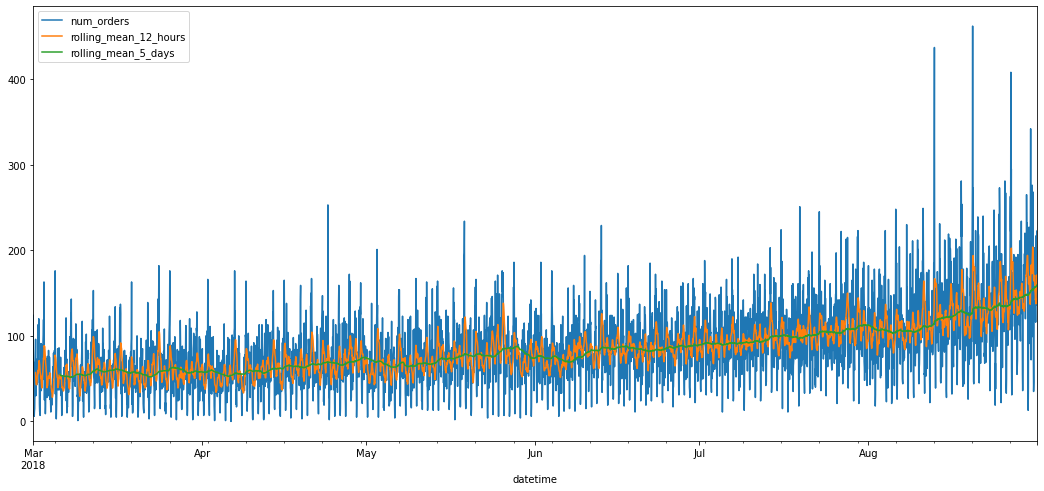

In [41]:
df['rolling_mean_12_hours'] = df['num_orders'].rolling(12).mean()
df['rolling_mean_5_days'] = df['num_orders'].rolling(120).mean()
df.plot( figsize = (18,8))
None

- Тренд на увеличения тут не так очевиден, как при ре-сэмплировании по неделям и месяцам, но он всё же очевиден.
    
- Проведем декомпозицию.

In [49]:
display(decomposed.weights )

datetime
2018-03-01 00:00:00    1.0
2018-03-01 01:00:00    1.0
2018-03-01 02:00:00    1.0
2018-03-01 03:00:00    1.0
2018-03-01 04:00:00    1.0
                      ... 
2018-08-31 19:00:00    1.0
2018-08-31 20:00:00    1.0
2018-08-31 21:00:00    1.0
2018-08-31 22:00:00    1.0
2018-08-31 23:00:00    1.0
Freq: H, Name: weights, Length: 4416, dtype: float64

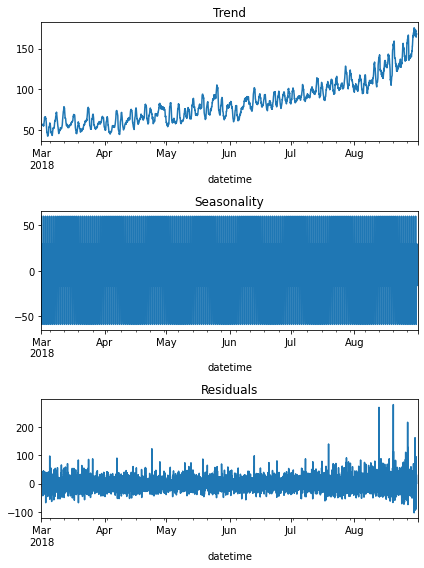

In [42]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

- Проведем декомпозицию скользящего среднего.

In [50]:
df = df.fillna(value = df['2018-03-01':'2018-03-02']['num_orders'].mean())

In [51]:
df['rolling_mean_12_hours'] = df['rolling_mean_12_hours'].astype('int')
df['rolling_mean_5_days'] = df['rolling_mean_5_days'].astype('int')

In [52]:
df.head()

,num_orders,rolling_mean_12_hours,rolling_mean_5_days
datetime,,,
2018-03-01 00:00:00,124,59,59
2018-03-01 01:00:00,85,59,59
2018-03-01 02:00:00,71,59,59
2018-03-01 03:00:00,66,59,59
2018-03-01 04:00:00,43,59,59


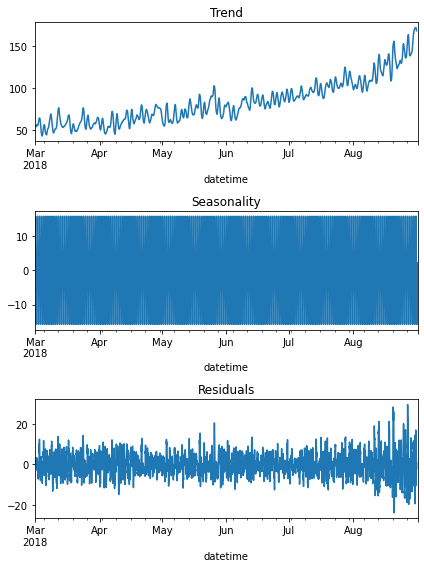

In [53]:
decomposed = seasonal_decompose(df['rolling_mean_12_hours'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

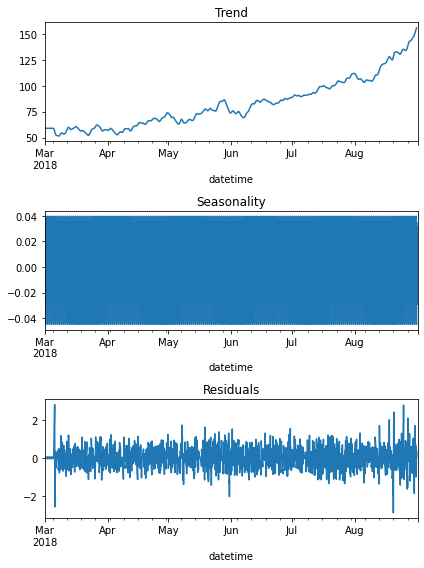

In [21]:
decomposed = seasonal_decompose(df['rolling_mean_5_days'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

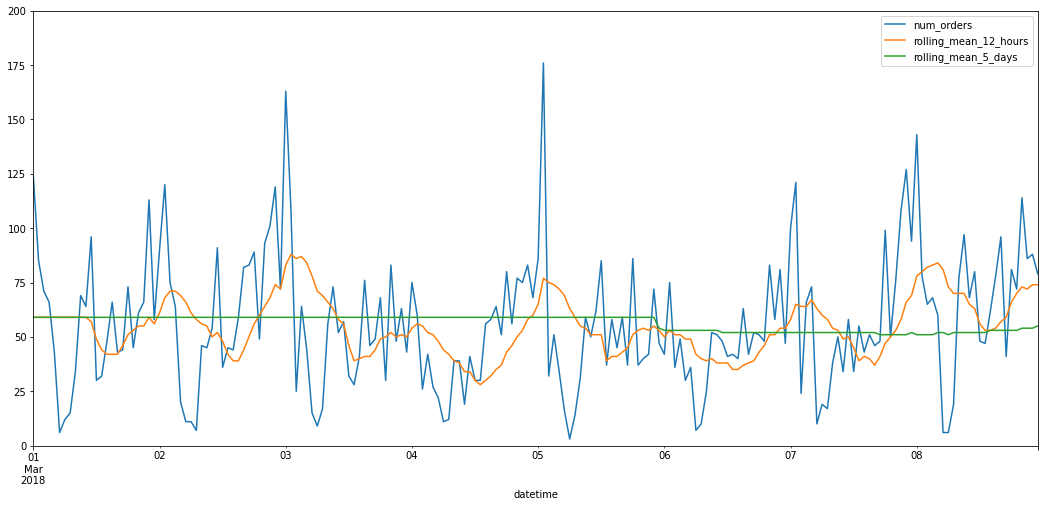

In [55]:
df['2018-03-01':'2018-03-08'].plot(ylim = (0,200), figsize = (18, 8))
None

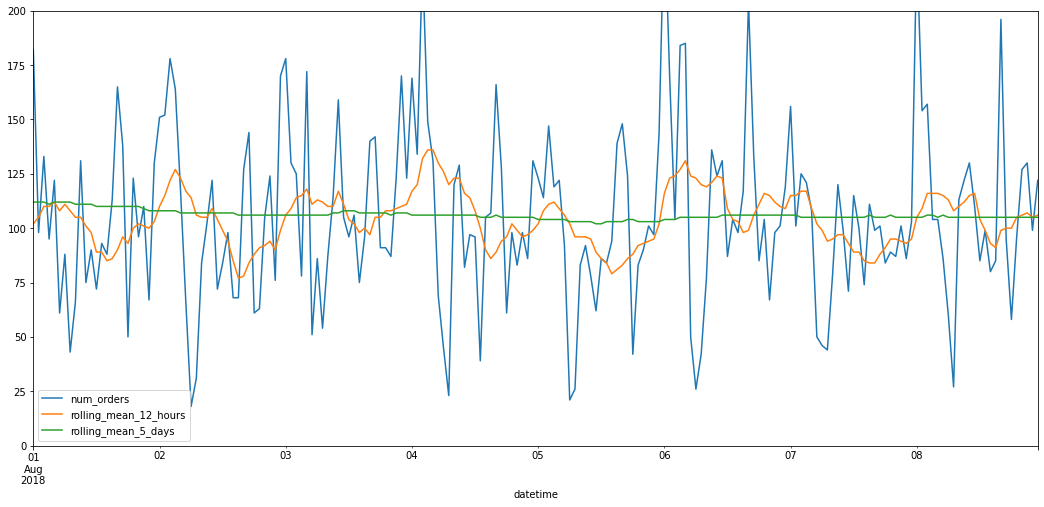

In [56]:
df['2018-08-01':'2018-08-08'].plot(ylim = (0,200), figsize = (18, 8))
None

- Тренд на рост заказов очевиден, так же усилилась дисперсия в сравнении между мартом и августом.
- Так же, если в марте минимальное число заказов в час опускалось почти до нуля, то в августе уже минимум 20 заказов в час.
- Посмотрим разность между ежечастными заказами.

<AxesSubplot:xlabel='datetime'>

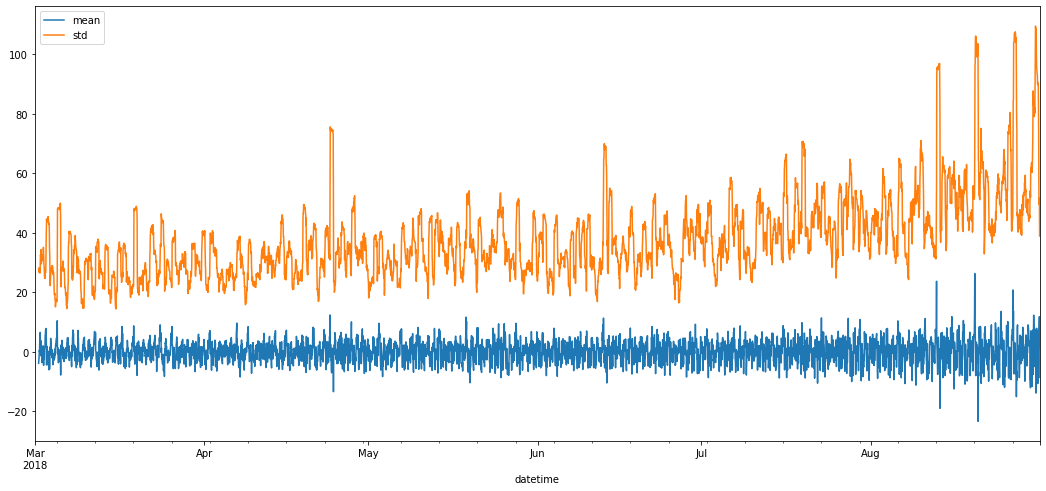

In [57]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(15).mean()
df_shift['std'] = df_shift['num_orders'].rolling(15).std()
df_shift['mean'].plot(legend = True)
df_shift['std'].plot(figsize = (18,8), legend = True)

In [66]:
df.loc[df_shift['num_orders'].idxmax()]

num_orders               253
rolling_mean_12_hours     88
rolling_mean_5_days       69
Name: 2018-04-24 00:00:00, dtype: int64

In [67]:
df.loc[df['num_orders'].idxmax()]

num_orders               462
rolling_mean_12_hours    178
rolling_mean_5_days      129
Name: 2018-08-20 02:00:00, dtype: int64

- Еще раз видим, что скачки в количестве заказов/час растут, а максимальное количество заказов за час составило 462 заказа. Произошло это очень близко к концу выборки. Пытался найти, что такого было в 2 часа ночи в тот день - неизвестно. Это была среда.
   
- Удаляем ненужные столбцы, и переходим к работе с моделями.    


In [68]:
df = df.drop(['rolling_mean_12_hours', 'rolling_mean_5_days'], axis = 1)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Обучение

- Созадим фичи для нашей будущей модели регрессии. 

In [70]:
def make_features(data2, max_lag, rolling_mean_size):
    data = data2.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [73]:
df_feature = make_features(df, 20, 12)

In [74]:
display(df_feature.head())
display(df_feature.info())

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int64  
 2   day           4416 non-null   int64  
 3   hour          4416 non-null   int64  
 4   dayofweek     4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-null   float64
 17  lag_13        4403 non-null

None

<div class = "alert alert-info" style="border-left: 14px deep blue">
<b>Комментарий студента</b>
    
Всё работает, давайте разбивать на выборки и обучать модели.
</div>

In [75]:
train, test = train_test_split(df_feature, shuffle=False, test_size=0.1)
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3954 entries, 2018-03-01 20:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3954 non-null   int64  
 1   month         3954 non-null   int64  
 2   day           3954 non-null   int64  
 3   hour          3954 non-null   int64  
 4   dayofweek     3954 non-null   int64  
 5   lag_1         3954 non-null   float64
 6   lag_2         3954 non-null   float64
 7   lag_3         3954 non-null   float64
 8   lag_4         3954 non-null   float64
 9   lag_5         3954 non-null   float64
 10  lag_6         3954 non-null   float64
 11  lag_7         3954 non-null   float64
 12  lag_8         3954 non-null   float64
 13  lag_9         3954 non-null   float64
 14  lag_10        3954 non-null   float64
 15  lag_11        3954 non-null   float64
 16  lag_12        3954 non-null   float64
 17  lag_13        3954 non-null

In [77]:
features_train=train.drop (['num_orders'], axis = 1)
target_train=train['num_orders']

features_test=test.drop (['num_orders'], axis = 1)
target_test=test['num_orders']

In [78]:
model = LinearRegression(normalize = True)
model.fit(features_train, target_train)

LinearRegression(normalize=True)

In [79]:
model_v2 = LinearRegression(fit_intercept = False) 
model_v2.fit(features_train, target_train)

LinearRegression(fit_intercept=False)

In [80]:
train_pred = model.predict(features_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)

RMSE обучающей выборки: 28.955741265704184


In [81]:
train_pred_v2 = model_v2.predict(features_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred_v2)**0.5)

RMSE обучающей выборки: 28.952178092219597


- При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы используем TimeSeriesSplit.

In [82]:
%%time
model2 = RandomForestRegressor()
parametrs = {'n_estimators': range (10, 171, 40),
              'max_depth': range (1,11, 2),
              'min_samples_leaf': range (1,5),
              'min_samples_split': range (2,9,2) }
grid = GridSearchCV(model2, parametrs, cv = TimeSeriesSplit(n_splits=4), verbose = 1)
grid.fit(features_train, target_train)

grid.best_params_

Fitting 4 folds for each of 400 candidates, totalling 1600 fits
CPU times: user 23min 10s, sys: 3.16 s, total: 23min 14s
Wall time: 23min 18s


{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 130}

In [83]:
model2 = RandomForestRegressor(max_depth =9, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 130)
model2.fit(features_train, target_train)
train_pred2 = model2.predict(features_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred2)**0.5)

RMSE обучающей выборки: 15.922393966215381


In [84]:
model3 = CatBoostRegressor(iterations=2, depth=2, learning_rate=0.5, loss_function='RMSE', logging_level='Verbose')
model3_v2 = CatBoostRegressor(learning_rate=0.2, loss_function='RMSE')

model3.fit(features_train, target_train)
model3_v2.fit(features_train, target_train)

train_pred3 = model3.predict(features_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred3)**0.5)
train_pred3_v2 = model3_v2.predict(features_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred3_v2)**0.5)

0:	learn: 34.7091776	total: 47.7ms	remaining: 47.7ms
1:	learn: 32.0711332	total: 49.2ms	remaining: 0us
0:	learn: 35.4458961	total: 8.85ms	remaining: 8.84s
1:	learn: 33.3703745	total: 14.4ms	remaining: 7.2s
2:	learn: 31.0534703	total: 20.1ms	remaining: 6.68s
3:	learn: 29.5452471	total: 25.7ms	remaining: 6.4s
4:	learn: 28.4139793	total: 31.3ms	remaining: 6.24s
5:	learn: 27.1186364	total: 37.1ms	remaining: 6.15s
6:	learn: 26.1015101	total: 42.8ms	remaining: 6.07s
7:	learn: 25.4538469	total: 48.5ms	remaining: 6.01s
8:	learn: 25.0693447	total: 54.2ms	remaining: 5.97s
9:	learn: 24.5027653	total: 59.8ms	remaining: 5.92s
10:	learn: 24.1801926	total: 65.3ms	remaining: 5.87s
11:	learn: 24.0831201	total: 70.4ms	remaining: 5.8s
12:	learn: 23.7157462	total: 76.2ms	remaining: 5.78s
13:	learn: 23.6589106	total: 81.5ms	remaining: 5.74s
14:	learn: 23.6147018	total: 86.7ms	remaining: 5.69s
15:	learn: 23.3876715	total: 92.1ms	remaining: 5.66s
16:	learn: 23.1052410	total: 97.6ms	remaining: 5.65s
17:	learn

161:	learn: 14.2306518	total: 949ms	remaining: 4.91s
162:	learn: 14.1936367	total: 958ms	remaining: 4.92s
163:	learn: 14.1629367	total: 966ms	remaining: 4.93s
164:	learn: 14.1501966	total: 975ms	remaining: 4.93s
165:	learn: 14.1012300	total: 983ms	remaining: 4.94s
166:	learn: 14.0603815	total: 990ms	remaining: 4.94s
167:	learn: 14.0113098	total: 999ms	remaining: 4.95s
168:	learn: 13.9562051	total: 1.01s	remaining: 4.95s
169:	learn: 13.9246838	total: 1.01s	remaining: 4.96s
170:	learn: 13.8655698	total: 1.02s	remaining: 4.95s
171:	learn: 13.8551969	total: 1.03s	remaining: 4.94s
172:	learn: 13.8534482	total: 1.03s	remaining: 4.93s
173:	learn: 13.8223235	total: 1.04s	remaining: 4.92s
174:	learn: 13.7713613	total: 1.04s	remaining: 4.91s
175:	learn: 13.7417517	total: 1.05s	remaining: 4.9s
176:	learn: 13.7032158	total: 1.05s	remaining: 4.89s
177:	learn: 13.6546473	total: 1.06s	remaining: 4.89s
178:	learn: 13.6205918	total: 1.06s	remaining: 4.88s
179:	learn: 13.5779463	total: 1.07s	remaining: 

319:	learn: 9.7593574	total: 1.89s	remaining: 4.01s
320:	learn: 9.7389324	total: 1.89s	remaining: 4.01s
321:	learn: 9.7171474	total: 1.9s	remaining: 4s
322:	learn: 9.6967559	total: 1.91s	remaining: 3.99s
323:	learn: 9.6585248	total: 1.91s	remaining: 3.99s
324:	learn: 9.6280600	total: 1.92s	remaining: 3.98s
325:	learn: 9.6100166	total: 1.92s	remaining: 3.97s
326:	learn: 9.5900270	total: 1.93s	remaining: 3.97s
327:	learn: 9.5766423	total: 1.93s	remaining: 3.96s
328:	learn: 9.5662611	total: 1.94s	remaining: 3.96s
329:	learn: 9.5430769	total: 1.95s	remaining: 3.96s
330:	learn: 9.5239927	total: 1.96s	remaining: 3.96s
331:	learn: 9.4950814	total: 1.97s	remaining: 3.96s
332:	learn: 9.4800202	total: 1.97s	remaining: 3.96s
333:	learn: 9.4791303	total: 1.98s	remaining: 3.95s
334:	learn: 9.4510766	total: 1.99s	remaining: 3.95s
335:	learn: 9.4311019	total: 1.99s	remaining: 3.94s
336:	learn: 9.4125448	total: 2s	remaining: 3.93s
337:	learn: 9.3907083	total: 2s	remaining: 3.93s
338:	learn: 9.3724240	

504:	learn: 6.7601504	total: 3.02s	remaining: 2.96s
505:	learn: 6.7500431	total: 3.03s	remaining: 2.96s
506:	learn: 6.7434349	total: 3.03s	remaining: 2.95s
507:	learn: 6.7312353	total: 3.04s	remaining: 2.94s
508:	learn: 6.7201722	total: 3.04s	remaining: 2.94s
509:	learn: 6.7045625	total: 3.05s	remaining: 2.93s
510:	learn: 6.6962380	total: 3.06s	remaining: 2.92s
511:	learn: 6.6854643	total: 3.06s	remaining: 2.92s
512:	learn: 6.6715573	total: 3.07s	remaining: 2.91s
513:	learn: 6.6519345	total: 3.07s	remaining: 2.9s
514:	learn: 6.6414079	total: 3.08s	remaining: 2.9s
515:	learn: 6.6303500	total: 3.08s	remaining: 2.89s
516:	learn: 6.6182866	total: 3.09s	remaining: 2.89s
517:	learn: 6.5929380	total: 3.1s	remaining: 2.88s
518:	learn: 6.5788721	total: 3.1s	remaining: 2.87s
519:	learn: 6.5642745	total: 3.11s	remaining: 2.87s
520:	learn: 6.5479501	total: 3.11s	remaining: 2.86s
521:	learn: 6.5299226	total: 3.12s	remaining: 2.85s
522:	learn: 6.5179342	total: 3.12s	remaining: 2.85s
523:	learn: 6.51

686:	learn: 4.8593489	total: 4.15s	remaining: 1.89s
687:	learn: 4.8450989	total: 4.16s	remaining: 1.89s
688:	learn: 4.8414894	total: 4.16s	remaining: 1.88s
689:	learn: 4.8391826	total: 4.17s	remaining: 1.87s
690:	learn: 4.8225958	total: 4.17s	remaining: 1.87s
691:	learn: 4.8105144	total: 4.18s	remaining: 1.86s
692:	learn: 4.8013297	total: 4.18s	remaining: 1.85s
693:	learn: 4.7873057	total: 4.19s	remaining: 1.85s
694:	learn: 4.7767553	total: 4.2s	remaining: 1.84s
695:	learn: 4.7723082	total: 4.2s	remaining: 1.83s
696:	learn: 4.7668882	total: 4.21s	remaining: 1.83s
697:	learn: 4.7509977	total: 4.21s	remaining: 1.82s
698:	learn: 4.7452010	total: 4.22s	remaining: 1.82s
699:	learn: 4.7386500	total: 4.22s	remaining: 1.81s
700:	learn: 4.7311291	total: 4.23s	remaining: 1.8s
701:	learn: 4.7227882	total: 4.23s	remaining: 1.8s
702:	learn: 4.7112869	total: 4.24s	remaining: 1.79s
703:	learn: 4.7035852	total: 4.25s	remaining: 1.78s
704:	learn: 4.6867816	total: 4.25s	remaining: 1.78s
705:	learn: 4.68

877:	learn: 3.5591497	total: 5.28s	remaining: 733ms
878:	learn: 3.5531052	total: 5.28s	remaining: 727ms
879:	learn: 3.5394979	total: 5.29s	remaining: 721ms
880:	learn: 3.5347005	total: 5.29s	remaining: 715ms
881:	learn: 3.5289908	total: 5.3s	remaining: 709ms
882:	learn: 3.5288964	total: 5.31s	remaining: 703ms
883:	learn: 3.5202694	total: 5.31s	remaining: 697ms
884:	learn: 3.5183869	total: 5.32s	remaining: 691ms
885:	learn: 3.5098711	total: 5.33s	remaining: 685ms
886:	learn: 3.5042307	total: 5.33s	remaining: 679ms
887:	learn: 3.4984246	total: 5.34s	remaining: 673ms
888:	learn: 3.4886670	total: 5.34s	remaining: 667ms
889:	learn: 3.4885719	total: 5.35s	remaining: 661ms
890:	learn: 3.4828589	total: 5.35s	remaining: 655ms
891:	learn: 3.4768219	total: 5.36s	remaining: 649ms
892:	learn: 3.4688589	total: 5.36s	remaining: 643ms
893:	learn: 3.4639744	total: 5.37s	remaining: 637ms
894:	learn: 3.4638297	total: 5.38s	remaining: 631ms
895:	learn: 3.4580525	total: 5.38s	remaining: 624ms
896:	learn: 3

In [85]:
model4 = DummyRegressor(strategy = 'mean')
model4.fit(features_train, target_train)
model4_v2 = DummyRegressor(strategy = 'median')
model4_v2.fit(features_train, target_train)

DummyRegressor(strategy='median')

In [86]:
train_pred4 = model4.predict(features_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred4)**0.5)
train_pred4_v2 = model4_v2.predict(features_train)
print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred4_v2)**0.5)

RMSE обучающей выборки: 38.67009372217694
RMSE обучающей выборки: 38.82077217223478


## Результаты валидации моделей

|  Модель  | RMSE на обучающей выборке | RMSE на тестовой выборке |
|----------|---------------------------|--------------------------|
| LinearRegression        | 29.0 | ? |
| LinearRegression_v2     | 29.0 | ? |
| RandomForestRegressor   | 16.0 | ? |
| CatBoostRegressor       | 32.1 | ? |
| CatBoostRegressor_v2    |  2.9 | ? |
| DummyRegressor          | 38.7 | ? |
| DummyRegressor_v2       | 38.8 | ? |

- С огромным отрывом лидирует:
    
    model3_v2 = CatBoostRegressor(learning_rate=0.2, loss_function='RMSE')
    
Проверим, так ли она хороша на тестовой выборке.

## Тестирование

In [104]:
test_pred = model.predict(features_test)
print(f"RMSE линейной регрессии на тестовой выборке:  {mean_squared_error(target_test, test_pred)**0.5:.2f}")
test_pred_v2 = model_v2.predict(features_test)
print(f"RMSE линейной регрессии v2 на тестовой выборке: {mean_squared_error(target_test, test_pred_v2)**0.5:.2f}")
test_pred2 = model2.predict(features_test)
print(f"RMSE случайного леса на тестовой выборке: { mean_squared_error(target_test, test_pred2)**0.5:.2f}")
test_pred3 = model3.predict(features_test)
print(f"RMSE CatBoostRegressor на тестовой выборке: { mean_squared_error(target_test, test_pred3)**0.5:.2f}")
test_pred3_v2 = model3_v2.predict(features_test)
print(f"RMSE CatBoostRegressor v2 на тестовой выборке: { mean_squared_error(target_test, test_pred3_v2)**0.5:.2f}")
train_pred4 = model4.predict(features_test)
print(f"RMSE Dummy модели на тестовой выборке:{ mean_squared_error(target_test, train_pred4)**0.5:.2f}")
train_pred4_v2 = model4_v2.predict(features_test)
print(f"RMSE Dummy модели на тестовой выборке:{ mean_squared_error(target_test, train_pred4_v2)**0.5:.2f}")

RMSE линейной регрессии на тестовой выборке:  54.01
RMSE линейной регрессии v2 на тестовой выборке: 54.46
RMSE случайного леса на тестовой выборке: 45.37
RMSE CatBoostRegressor на тестовой выборке: 72.39
RMSE CatBoostRegressor v2 на тестовой выборке: 42.83
RMSE Dummy модели на тестовой выборке:84.65
RMSE Dummy модели на тестовой выборке:87.15


|  Модель  | RMSE на обучающей выборке | RMSE на тестовой выборке |
|----------|---------------------------|--------------------------|
| LinearRegression        | 29.0 | 54.01 |
| LinearRegression_v2     | 29.0 | 54.46 |
| RandomForestRegressor   | 16.0 | 45.09 |
| CatBoostRegressor       | 32.1 | 72.39 |
| CatBoostRegressor_v2    |  2.9 | 42.82 |
| DummyRegressor          | 38.7 | 84.65 |
| DummyRegressor_v2       | 38.8 | 87.15 |

- По результатам тестовой выборки, наименьший RMSE, равный 42.82 у выбранной нами ранее модели:
    
        CatBoostRegressor(learning_rate=0.2, loss_function='RMSE')
 
- На втором месте с результатом RMSE, равным 45.09:
    
        RandomForestRegressor(max_depth =9, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 130) 


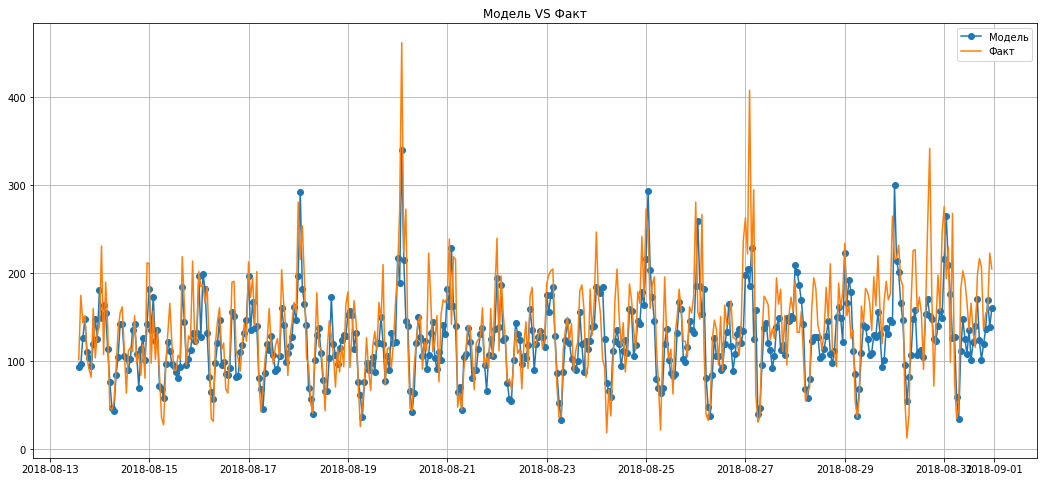

In [105]:
plt.figure(figsize=(18,8))
plt.title('Модель VS Факт')
plt.plot(target_test.index, test_pred3_v2, 'o-', label='Модель')
plt.plot(target_test.index, target_test.values, label='Факт')
plt.legend()
plt.grid(True)

<div class = "alert alert-info" style="border-left: 14px deep blue">
    
Не знаю, стоит ли это отмечать, но на тестовой выборке результат значительно хуже, чем на треннировочной. Оно и очевидно, а так же стоит отметить, что у нас наблюдается ускоряющийся тренд роста, особенно хорошо это видно на графиках, где ресемплирование шло по дням.
    
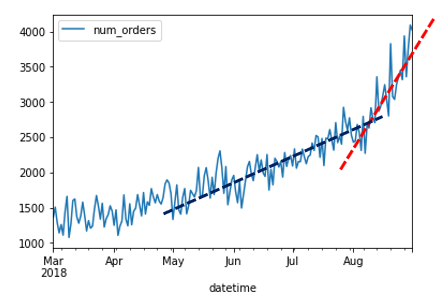
    
В тестовую выборку попал весь август, во время которого скорость роста числа пользователей ощутимо увеличилась. Если бы выборку начать не с марта, а с июня и захватить первые 2 недели августа, а на тестовую выборку взять только 2 последние недели, вероятнее всего качество модели бы значительно выросло. 
</div>

## Вывод


В работе мы провели ресеплирование и анализ данных, подготовку выборок, обучение моделей, а так же их тестирование и выбор лучшей модели. 

Для полученных данных лучше всего подходит модель 

        CatBoostRegressor(learning_rate=0.2, loss_function='RMSE')